# E03 - Spike detection

Note: on the website you will find two different signals: `E03_signal1.csv` and `E03_signal2.csv`. You will need to solve this notebook for both signals, unless it is specified to do differently

## Load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('../signals/E03_signal1.csv').values # Change filename here

## Inspect the data

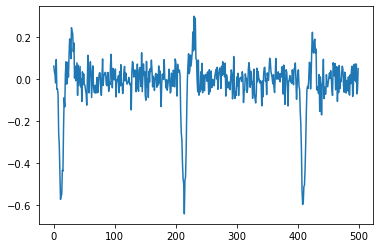

In [2]:
plt.figure()
plt.plot(data[2000:2500])
plt.show()

## Detect spikes with a threshold-based approach

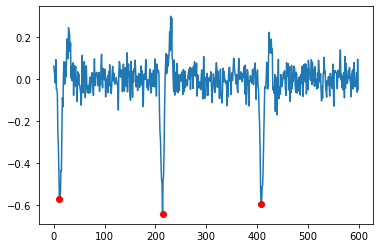

In [3]:
from scipy.signal import find_peaks

# Find spikes
pk_loc = find_peaks(np.abs(data).flatten(), height=0.4, distance=30)[0]

# Plot identified spikes on a portion of the signal
pk_loc_to_plot = pk_loc[(pk_loc>2000) & (pk_loc<2600)]
plt.figure()
plt.plot(data[2000:2600])
plt.plot(pk_loc_to_plot-2000, data[pk_loc_to_plot], 'ro')
plt.show()

## Hypothesize the correct number of firing neurons

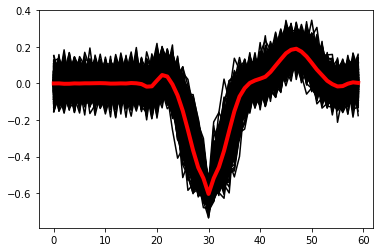

In [4]:
# Segment all the spikes
spikes = []
for loc in pk_loc:
    spikes.append(data[loc-30:loc+30])
spikes = np.asarray(spikes).squeeze()

# Plot all the spikes
plt.figure()
plt.plot(spikes.transpose(), 'k')
plt.plot(np.mean(spikes, axis=0), 'r', lw=4)
plt.show()

## If a single neuron is present, determine its firing rate

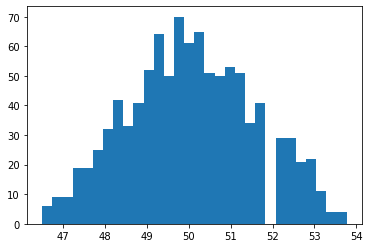

Average firing rate (standard deviation): 	50.05 (1.51) Hz.


In [5]:
# Plot histogram of the firing rate
inst_fr = 10000/(np.diff(pk_loc))
plt.figure()
plt.hist(inst_fr, bins=30)
plt.show()

# Print average firing rate
print(f'Average firing rate (standard deviation): \t{np.mean(inst_fr):.2f} ({np.std(inst_fr):.2f}) Hz.')

## Detect spikes with a template matching procedure

### Define a template

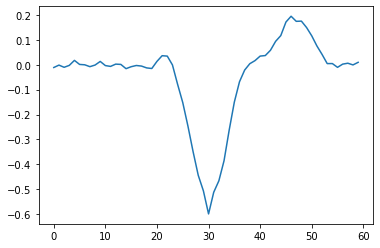

In [6]:
# Define a template as the average of the first 30 identified spikes
temp_matrix = []
for loc in pk_loc[:30]:
    temp_matrix.append(data[loc-30:loc+30])
template = np.mean(np.asarray(temp_matrix).squeeze(), axis=0)

plt.figure()
plt.plot(template)
plt.show()

### Calculate the correlation

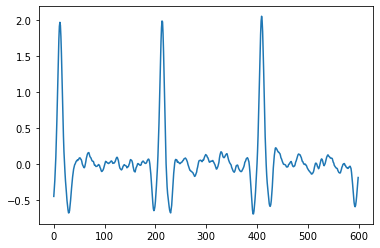

In [7]:
from scipy.signal import correlate

x_corr = correlate(data.reshape(-1,1), template.reshape(-1,1), mode='same') # The 'same' option centers correlation and calculates it with the same length as the first input

plt.figure()
plt.plot(x_corr[2000:2600])
plt.show()

### Find spikes from the correlation

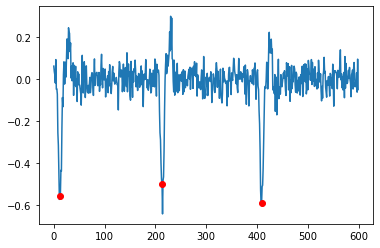

In [8]:
pk_loc_corr = find_peaks(x_corr.flatten(), height=1, distance=30)[0]

# Plot identified spikes on a portion of the signal
pk_loc_to_plot = pk_loc_corr[(pk_loc_corr>2000) & (pk_loc_corr<2600)]
plt.figure()
plt.plot(data[2000:2600])
plt.plot(pk_loc_to_plot-2000, data[pk_loc_to_plot], 'ro')
plt.show()

## Draw ROC curve (optional, only for `E03_signal1.csv`)

On the website you will find a file `E03_indexes1_0.csv` containing the true firing instants for each neuron (careful, those indexes refer to the initial point of the spike, not to its peak). Try to use this information to evaluate, in terms of ROC curve, your threshold-based detector

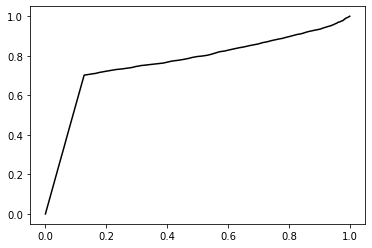

In [12]:
indexes = pd.read_csv('../signals/E03_index1_0.csv').values.flatten()

# Build the ground truth signal (0 when the neuron is not firing, 1 during the spike)
gt_signal = np.zeros(data.size)
for i in indexes:
    gt_signal[i:i+60] = 1

# Define thresholds to test
ths = np.linspace(0,1,1000)

sens = []
spec = []

for t in ths:
    pk_t = find_peaks(np.abs(data).flatten(), height=t, distance=30)[0]
    # Generate spiking signal in the same way as the ground truth
    pk_signal = np.zeros(data.size)
    for p in pk_t:
        pk_signal[p-29:p+31] = 1
    sens.append((np.sum((pk_signal == 1) & (gt_signal == 1)))/np.sum(gt_signal==1))
    spec.append((np.sum((pk_signal == 0) & (gt_signal == 0)))/(np.sum(gt_signal==0)))

sens = np.asarray(sens)
spec = np.asarray(spec)

plt.figure()
plt.plot(1-spec, sens, 'k')
plt.show()
